In [2]:
def tail(filename, lines=10):
    with open(filename, 'rb') as file:
        # Move the file pointer to the end
        file.seek(0, 2)
        # Find the start position of the last n lines
        pos = file.tell()
        lines_found = 0
        while pos > 0 and lines_found < lines:
            pos -= 1
            file.seek(pos)
            if file.read(1) == b'\n':
                lines_found += 1

        # Read the last n lines
        last_lines = file.readlines()[-lines:]

    return last_lines


In [3]:
# Tweak path before importing
import sys

sys.path.insert(0, '..')

import nn_rbf
import torch

In [4]:
# Load verification data
x_verification = torch.linspace(0, 2, 1000)
y_verification = torch.exp(x_verification)

import matplotlib.pyplot as plt

N = 20

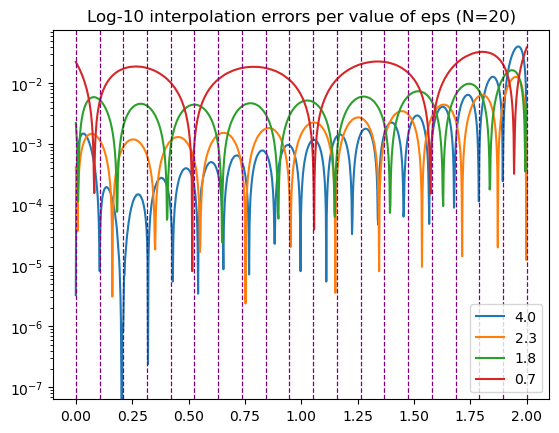

In [10]:
centers = torch.linspace(0, 2, 20)

for float_coef in ['4.0', '2.3', '1.8', '0.7']:
    filename = f'../coefs/20-{float_coef}.csv'
    result = tail(filename, lines=2)
    parsed_result = result[0].decode('utf-8')[:-2]
    
    # Get list of parameters
    alphas_list = [float(entry) for entry in parsed_result.split(',')[:-1]]

    # Get interpolant
    interp = nn_rbf.RBFInterpolant(centers = centers, eps = float(float_coef), alphas = alphas_list)

    # Get errors list
    errors_list = torch.abs(y_verification - interp(x_verification)).detach().numpy()

    plt.semilogy(x_verification.detach(), torch.abs(y_verification - interp(x_verification)).detach().numpy(), label=float_coef)
plt.title('Log-10 interpolation errors per value of eps (N=20)')
for x in torch.linspace(0, 2, 20).detach().numpy():
    plt.axvline(x, linestyle='--', linewidth=.9, color = 'purple')
plt.legend()
plt.show()

In [6]:
# Define RBF utilities (1D)
import numpy as np

def rbf_function(radius: np.ndarray, eps: float):
    return np.exp(-eps ** 2 * radius ** 2)

def get_rbf_matrix(interpolation_points: np.ndarray, centers: np.ndarray, eps: float = 0.1) -> np.ndarray:
    rbf_matrix = np.zeros(shape = (centers.shape[0], centers.shape[0]))
    for row_index in range(centers.shape[0]):
        rbf_matrix[row_index, :] = rbf_function(radius = np.abs(interpolation_points[row_index] - centers),
                                                 eps = eps)
    return rbf_matrix

from typing import Callable
def get_rbf_interpolant(interpolation_points: np.ndarray, centers: np.ndarray, 
                        interpolation_targets: np.ndarray, eps: float = 0.1) -> Callable:
    matrix = get_rbf_matrix(interpolation_points, centers, eps)
    coefficients = np.linalg.solve(matrix, interpolation_targets)
    def fn(x: float):
        return np.dot(rbf_function(radius = np.abs(x - centers), eps = eps), coefficients)
    return fn

def get_rbf_interpolant_wrong(interpolation_points: np.ndarray, centers: np.ndarray, 
                        interpolation_targets: np.ndarray, eps: float = 0.1) -> Callable:
    matrix = get_rbf_matrix(interpolation_points, centers, eps)
    coefficients = np.matmul(np.linalg.inv(matrix), interpolation_targets)
    def fn(x: float):
        return np.dot(rbf_function(radius = np.abs(x - centers), eps = eps), coefficients)
    return fn

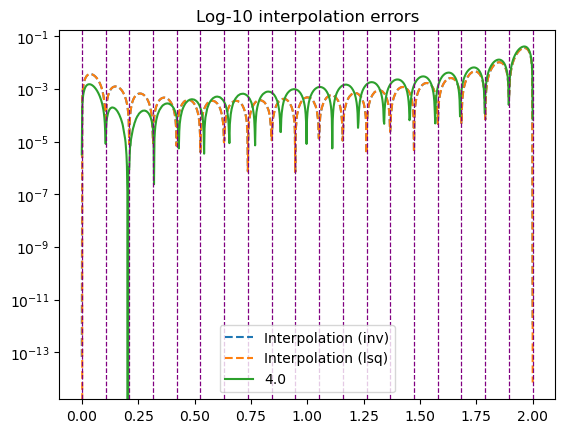

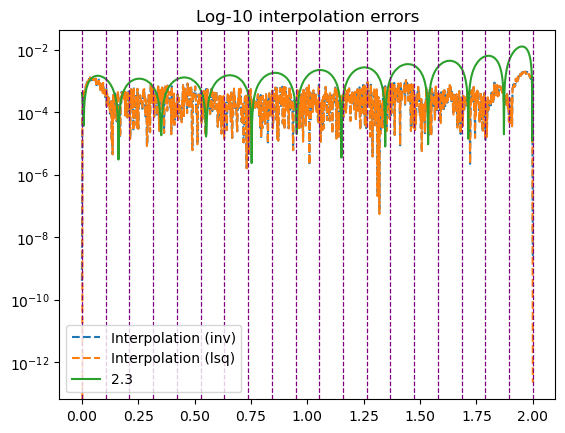

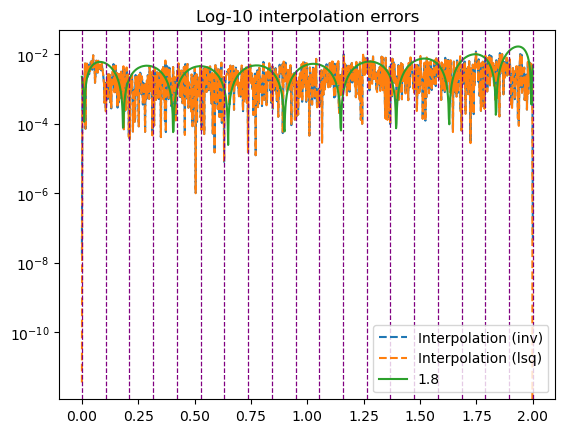

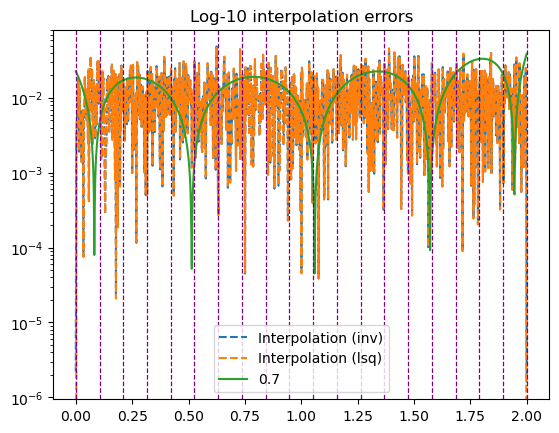

In [11]:
centers = torch.linspace(0, 2, 20)
centers_np = centers.detach().numpy()

for float_coef in ['4.0', '2.3', '1.8', '0.7']:
    filename = f'../coefs/20-{float_coef}.csv'
    result = tail(filename, lines=2)
    parsed_result = result[0].decode('utf-8')[:-2]
    
    # Get list of parameters
    alphas_list = [float(entry) for entry in parsed_result.split(',')[:-1]]

    # Get interpolant
    interp = nn_rbf.RBFInterpolant(centers = centers, eps = float(float_coef), alphas = alphas_list)

    # Get errors list
    errors_list = torch.abs(y_verification - interp(x_verification)).detach().numpy()


    fun_wrong = get_rbf_interpolant_wrong(centers_np, centers_np, torch.exp(centers).detach().numpy(), eps = float(float_coef))
    y_interp_wrong = [fun_wrong(x_int) for x_int in x_verification.detach().numpy()]
    plt.semilogy(x_verification.detach(), torch.abs(y_verification - torch.tensor(y_interp_wrong)), label="Interpolation (inv)", linestyle='--')

    fun_right = get_rbf_interpolant(centers_np, centers_np, torch.exp(centers).detach().numpy(), eps = float(float_coef))
    y_interp_right = [fun_right(x_int) for x_int in x_verification.detach().numpy()]
    plt.semilogy(x_verification.detach(), torch.abs(y_verification - torch.tensor(y_interp_right)), label="Interpolation (lsq)", linestyle='--')
    
    plt.semilogy(x_verification.detach(), torch.abs(y_verification - interp(x_verification)).detach().numpy(), label=float_coef)
    plt.title('Log-10 interpolation errors')
    for x in torch.linspace(0, 2, 20).detach().numpy():
        plt.axvline(x, linestyle='--', linewidth=.9, color = 'purple')
    plt.legend()
    plt.show()